# Entendimento do Problema e Planejamento da Solução

    O que preciso entregar? 
            Web App com modelo em produção fazendo previsões de inadimplência e taxa de juros personalizada.
    
    O que precisa ser feito? 
             Construção do Modelo;
             Deployment do Modelo;
         
    Quais ferramentas utilizar? 
           - Python
               1. Biblioteca de manipulação de dados(Pandas,Numpy e Scipy)
               2. Biblioteca de Machine Learning (Scikit-Learn)
               3. Biblioteca de Balanceamento de Dados (Imbalanced Learn)
               4. Biblioteca de Vizualização de Dados (Matplotlib e Seaborn)
            - Flask (Escrever a Handler API)
            - Render (Cloud para Deployment)
            - Streamlit ou Hugging Face (Web APP)
    
    Como fazer? 
            1. Fazer todo o processo de construção do modelo;
            2. Escrever Handler API para chamar o pipeline de tratamento de dados e fazer request no modelo; 
            3. Fazer deployment da aplicação no Render; 
            4. Construir o webapp utilizando o streamlit;

## Metadados

1: Inadimplente
0: Não inadimplente


X1: Amount of the given credit (NT dollar): it includes
both the individual consumer credit and his/her family
(supplementary) credit.
 X2: Gender (1 = male; 2 = female).
 X3: Education (1 = graduate school; 2 = university;
3 = high school; 4 = others).
 X4: Marital status (1 = married; 2 = single; 3 = others).
 X5: Age (year).
 X6–X11: History of past payment. We tracked the past
monthly payment records (from April to September,
2005) as follows: X6 = the repayment status in Septem-
ber, 2005; X7 = the repayment status in August,
2005; . . .; X11 = the repayment status in April, 2005.
The measurement scale for the repayment status is:
1 = pay duly; 1 = payment delay for one month;
2 = payment delay for two months; . . .; 8 = payment
delay for eight months; 9 = payment delay for nine
months and above.
 X12–X17: Amount of bill statement (NT dollar).
X12 = amount of bill statement in September, 2005;
X13 = amount of bill statement in August,
2005; . . .; X17 = amount of bill statement in April, 2005.
 X18–X23: Amount of previous payment (NT dollar).
X18 = amount paid in September, 2005; X19 = amount
paid in August, 2005; . . .; X23 = amount paid in April,
2005.

# PASSO 0 - Imports

In [1]:
import math
import pandas as pd
import numpy  as np
import inflection
import requests
import random
import pickle
import warnings
import xgboost as xgb
import seaborn as sns


from boruta               import BorutaPy
from scipy                import stats      as ss
from matplotlib           import pyplot     as plt
from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

## 0.1 Loading Data

In [3]:
df_raw = pd.read_csv('data/dataset_trat.csv', sep=';')

In [4]:
df_raw.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,200510,20000,2,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,200510,120000,2,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,200510,90000,2,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,200510,50000,2,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,200510,50000,1,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [102]:
df_raw.shape

(30000, 26)

In [103]:
df_raw.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default'],
      dtype='object')

In [106]:
df_raw['SEX'].unique()

array([2, 1])

In [108]:
df_raw['SEX'] = df_raw['SEX'].apply(lambda x: 'male' if x==1 else 'female')

In [109]:
df_raw['SEX'].unique()

array(['female', 'male'], dtype=object)

In [111]:
df_raw['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [112]:
df_raw['EDUCATION'] = df_raw['EDUCATION'].apply(lambda x: 'graduate school' if x == 1 else 'university' if x==2 else
                                               'high school' if x==3 else 'others')

In [113]:
df_raw['EDUCATION'].unique()

array(['university', 'graduate school', 'high school', 'others'],
      dtype=object)

In [114]:
df_raw['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [115]:
df_raw['MARRIAGE'] = df_raw['MARRIAGE'].apply(lambda x: 'married' if x==1 else 'single' if x==2 else 'others')

In [117]:
df_raw['MARRIAGE'].unique()

array(['married', 'single', 'others'], dtype=object)

## 0.2 Divisão do Conjunto de Dados

In [118]:
df_raw.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [119]:
print("O dataset tem {:.2f}% de inadimplentes." .format(df_raw[df_raw['default'] == 1].shape[0]*100/df_raw.shape[0]))

O dataset tem 22.12% de inadimplentes.


In [120]:
# Out of Time(OOT)
df_OOT = df_raw[df_raw['SAFRA'] > 200604].copy()

In [121]:
df_OOT.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
21000,21001,200605,30000,male,university,married,36,1,-1,-1,...,1170,780,0,780,0,1170,0,0,0,0
21001,21002,200605,280000,male,high school,married,40,2,0,0,...,191291,189029,192023,10000,9000,8000,6738,6974,7600,1
21002,21003,200605,260000,male,university,married,37,0,0,0,...,23186,14117,15797,3203,6015,5055,2011,4078,4522,0
21003,21004,200605,200000,male,university,single,32,2,0,0,...,0,0,0,7600,4000,0,0,0,0,1
21004,21005,200605,80000,male,university,single,32,2,0,0,...,67352,74448,72928,3000,4005,2500,10000,0,5000,1


In [122]:
df_OOT['SAFRA'].groupby(df_OOT['SAFRA']).count()

SAFRA
200605    3000
200606    3000
200607    3000
Name: SAFRA, dtype: int64

In [123]:
df0_dev = df_raw[df_raw['SAFRA'] <= 200604].copy()
df0_dev.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,200510,20000,female,university,married,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,200510,120000,female,university,single,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,200510,90000,female,university,single,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,200510,50000,female,university,married,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,200510,50000,male,university,married,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [124]:
X_train , X_test , y_train , y_test = train_test_split(df0_dev.drop(columns=['default']), df0_dev['default'] ,test_size=0.3, random_state=123)

In [125]:
print("O dataset de treino tem {:.2f}% de inadimplentes." .format(df0_dev[df0_dev['default'] == 1].shape[0]*100/df0_dev.shape[0]))
print("O dataset de teste tem {:.2f}% de inadimplentes." .format(df_OOT[df_OOT['default'] == 1].shape[0]*100/df_OOT.shape[0]))

O dataset de treino tem 22.84% de inadimplentes.
O dataset de teste tem 20.44% de inadimplentes.


In [126]:
X_train['SAFRA'].groupby(X_train['SAFRA']).count()

SAFRA
200510    2103
200511    2124
200512    2110
200601    2081
200602    2075
200603    2102
200604    2105
Name: SAFRA, dtype: int64

In [127]:
X_test['SAFRA'].groupby(X_test['SAFRA']).count()

SAFRA
200510    897
200511    876
200512    890
200601    919
200602    925
200603    898
200604    895
Name: SAFRA, dtype: int64

In [128]:
df_train = pd.concat([X_train,y_train],axis=1)

In [129]:
df_train.shape

(14700, 26)

# PASSO 1 - Data Description

In [130]:
df1 = df_train.copy()

In [131]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of columns: {}' .format(df1.shape[1]))

Number of Rows: 14700
Number of columns: 26


In [132]:
df1.dtypes

ID            int64
SAFRA         int64
LIMIT_BAL     int64
SEX          object
EDUCATION    object
MARRIAGE     object
AGE           int64
PAY_0         int64
PAY_2         int64
PAY_3         int64
PAY_4         int64
PAY_5         int64
PAY_6         int64
BILL_AMT1     int64
BILL_AMT2     int64
BILL_AMT3     int64
BILL_AMT4     int64
BILL_AMT5     int64
BILL_AMT6     int64
PAY_AMT1      int64
PAY_AMT2      int64
PAY_AMT3      int64
PAY_AMT4      int64
PAY_AMT5      int64
PAY_AMT6      int64
default       int64
dtype: object

In [133]:
df1.isna().sum()

ID           0
SAFRA        0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [135]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributtes = df1.select_dtypes(exclude=['int64','float64'])

In [136]:
#Central Tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ID,1.0,20999.0,20998.0,10486.743265,10470.5,6071.227228,0.006844,-1.205114
1,SAFRA,200510.0,200604.0,94.0,200563.059252,200601.0,45.326799,-0.277704,-1.921162
2,LIMIT_BAL,10000.0,800000.0,790000.0,163042.427211,140000.0,128130.031752,1.011593,0.515652
3,AGE,21.0,79.0,58.0,35.351565,34.0,9.209641,0.755401,0.105934
4,PAY_0,-2.0,8.0,10.0,0.019116,0.0,1.126479,0.809450,2.997290
5,PAY_2,-2.0,8.0,10.0,-0.100204,0.0,1.205582,0.815935,1.584174
6,PAY_3,-2.0,8.0,10.0,-0.132313,0.0,1.214584,0.913145,2.370870
7,PAY_4,-2.0,8.0,10.0,-0.192789,0.0,1.172579,1.032905,3.617662
8,PAY_5,-2.0,8.0,10.0,-0.230068,0.0,1.143390,1.015291,3.857546
9,PAY_6,-2.0,8.0,10.0,-0.256667,0.0,1.168946,0.967905,3.218053


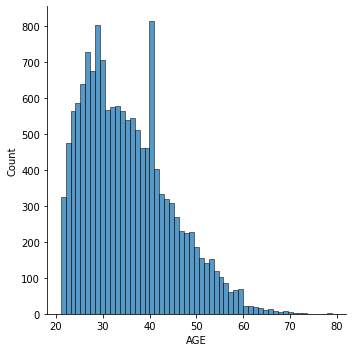

In [146]:
sns.displot(df1['AGE']);

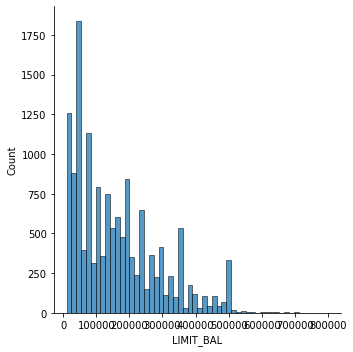

In [148]:
sns.displot(df1['LIMIT_BAL'],ax=ax2);

## 1.2 Categorical Attributes

In [149]:
cat_attributtes.apply(lambda x: x.unique().shape[0])

SEX          2
EDUCATION    4
MARRIAGE     3
dtype: int64

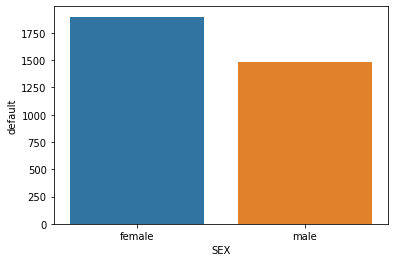

In [161]:
aux = df1[df1['default']==1]
aux1 = aux[['SEX','default']].groupby('SEX').sum().reset_index()
sns.barplot(data=aux1 , x='SEX' , y='default');

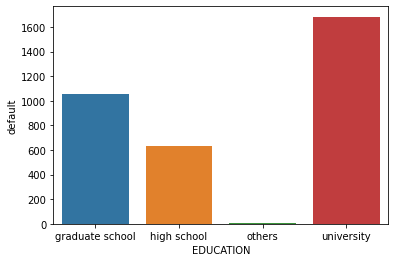

In [162]:
aux2 = aux[['EDUCATION','default']].groupby('EDUCATION').sum().reset_index()
sns.barplot(data=aux2 , x='EDUCATION' , y='default');

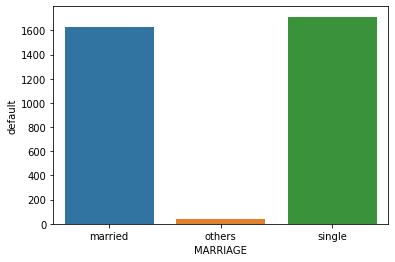

In [168]:
aux3 = aux[['MARRIAGE','default']].groupby('MARRIAGE').sum().reset_index()
sns.barplot(data=aux3 , x='MARRIAGE' , y='default');

# PASSO 2 - Feature Engeneering

In [164]:
df2 = df1.copy()

In [165]:
df2['SUM_BILL'] = df2['BILL_AMT1'] + df2['BILL_AMT2'] + df2['BILL_AMT3'] + df2['BILL_AMT4'] + df2['BILL_AMT5'] + df2['BILL_AMT6']   
df2['AVG_BILL'] = df2['SUM_BILL'] / 6
df2['max_BILL'] = df2[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)

df2['SUM_PAY'] = df2['PAY_AMT1'] + df2['PAY_AMT2'] + df2['PAY_AMT3'] + df2['PAY_AMT4'] + df2['PAY_AMT5'] + df2['PAY_AMT6']
df2['AVG_PAY'] = df2['SUM_PAY'] / 6
df2['max_PAY'] = df2[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']].max(axis=1)

In [166]:
df2.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default', 'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY',
       'max_PAY'],
      dtype='object')

In [167]:
df2['PAY_0'].unique()

array([ 0,  3, -1, -2,  1,  2,  4,  6,  8,  5,  7])

# PASSO 3 - Variable Filtering

In [27]:
df3 = df2.copy()

# PASSO 4 - EDA 

In [28]:
df4 = df3.copy()

## Análise Univariada

In [29]:
print(y_train.value_counts())

0    11322
1     3378
Name: default, dtype: int64


## Análise Bivariada

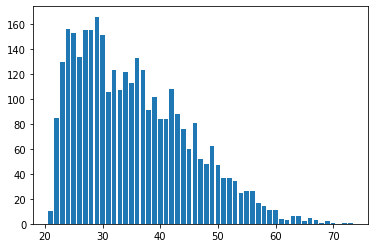

In [101]:
df4_aux = df4[df4['default']==1]
aux = df4_aux[['AGE','default']].groupby('AGE').sum().reset_index()
plt.bar(aux['AGE'], aux['default'])
plt.show()

In [88]:
aux.head()

,AGE,default
0,21,10
1,22,85
2,23,130
3,24,156
4,25,153


## Análise Multivariada

# PASSO 5 - Data Preparation 

In [30]:
df5 = df4.copy()

# PASSO 6 - Feature Selection 

In [31]:
df6 = df5.copy()

In [32]:
X = df6.drop(['default','ID','SAFRA'], axis=1)
y = df6['default']

X_train, X_test, y_train , y_test = train_test_split(X, y , stratify=y, shuffle=True)

In [33]:
#Define RandomForest Regressor
rf = RandomForestClassifier(n_jobs=-1)
#define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2).fit(X_train.values, y_train.values)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [93]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.copy()
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))
cols_selected_boruta

['PAY_0', 'BILL_AMT1']

# PASSO 7 - Machine Learning Modelling 

In [34]:
df7 = df6.copy()

In [40]:
X = df7.drop(['default','ID','SAFRA' ,'SEX', 'EDUCATION', 'MARRIAGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5'] , axis=1) 
y = df7['default']

X_train, X_test, y_train , y_test = train_test_split(X, y , stratify=y, shuffle=True)

In [42]:
cols_selected = ['LIMIT_BAL', 'AGE', 'PAY_AMT6']

In [43]:
#sem balanceamento
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score , cross_validate

num_folds = 10
seed = 7

kfold = KFold(num_folds, shuffle=True , random_state=seed)

model_tree = DecisionTreeClassifier()
result_tree=cross_val_score(model_tree,X_train,y_train,cv=kfold,scoring='accuracy')
print("Accuracy Value: {:.4f}" .format(result_tree.mean()))

Accuracy Value: 0.6736


In [59]:
X = np.array([[1000.0, 19.0 , 1000.0]])

In [61]:
model_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [63]:
model_tree.predict(X)[0]

1

# PASSO 8 - Hyperparameter Fine Tuning

# PASSO 9 - Tradução e Interpretação do Erro

# PASSO 10 - Deploy Model To Production

## 10.1 Credit Class

## 10.2 API Handler

## 10.3 API Tester

In [64]:
data = {"model": model_tree }
with open('saved_steps.pkl' , 'wb') as file:
    pickle.dump(data,file)

In [65]:
with open('saved_steps.pkl' , 'rb') as file:
    data =  pickle.load(file)

In [66]:
classificator = data['model']

In [77]:
classificator.predict(X)[0]

1

In [67]:
cols_selected

['LIMIT_BAL', 'AGE', 'PAY_AMT6']